<font color="#CC3D3D"><p>
# ML Case Study #3

### 1. Problem Definition
- The firm asks you to complete the analysis of predicting demographics of department store customers using purchase records. 
- Given the training and test files and training labels, predict the labels of the test data and submit the results in the csv format.

### 2. Data Collection

*Load Libraries*

In [1]:
%run import_modules.py
%matplotlib inline

*Read Transaction Data*

In [2]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()

df_train

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000
...,...,...,...,...,...,...,...
231999,3499,2007-12-17 00:00:00,본 점,127129,상품군미지정,기타,-135000
232000,3499,2007-12-23 00:00:00,노원점,285136,시티웨어,시티웨어,6380000
232001,3499,2007-12-23 00:00:00,노원점,39107,야채,농산물,40800
232002,3499,2007-12-27 00:00:00,본 점,740120,어덜트,명품,4880000


### 3. Data Preprocessing - Make Features

*Generate BOW based features*

In [3]:
level = 'gds_grp_nm'

train_test = pd.pivot_table(pd.concat([df_train, df_test]), index='cust_id', columns=level, values='amount',
                            aggfunc=lambda x: len(x), fill_value=0).reset_index()
#train_test = pd.pivot_table(pd.concat([df_train, df_test]), index='cust_id', columns=level, values='amount',
#                            aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0).reset_index()

train_test

gds_grp_nm,cust_id,14K,4대 B/D,"IT 게임기,S/W",KKD,L.B,L/C 아동복,L/C골프의류,L/C정장,MP3 外,...,한실침구,한차,햄,햄세트,향수,헤어ACC,홈웨어,화장품,회,휴지류
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,0,1,0,0,0,0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
5978,5978,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5979,5979,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5980,5980,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3. Data Preprocessing - Feature Engineering

*Normalize Features & Reduce Dimension*
*Reduce Dimension*

In [4]:
# 이상치(outlier)를 제거한다.
train_test.iloc[:,1:] = train_test.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다.
train_test.iloc[:,1:] = np.log1p(train_test.iloc[:,1:])
 # 로그변환할때 +1을 안하면 에러가 떠서 아에 numpy에서 +1라는 로그변환 코드를 만듬

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test.shape[1] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test.iloc[:,1:])
train_test = pd.concat([train_test.iloc[:,0], pd.DataFrame(pca)], axis=1)
display(train_test)

# 전처리 후 학습용과 제출용 데이터로 분리한다.
train_x = train_test.query('cust_id not in @IDtest').drop('cust_id', axis=1)
test_x = train_test.query('cust_id in @IDtest').drop('cust_id', axis=1)

,cust_id,0,1,2,3,4,5,6,7,8,...,96,97,98,99,100,101,102,103,104,105
0,0,1.376577,1.524210,-0.755290,-0.857018,-0.097539,0.284663,0.518532,-0.266509,-1.075355,...,0.076712,-0.306567,0.109445,0.246418,-0.066584,-0.107269,-0.107607,-0.064111,0.241903,-0.086065
1,1,-2.199270,-0.548905,-0.072556,-0.032198,0.082173,-0.224745,-0.024840,0.154271,0.164509,...,-0.116301,0.029510,0.095546,-0.022477,0.017875,-0.039455,0.073846,0.047649,-0.067310,0.074370
2,2,-1.628236,-0.197108,0.173076,-0.107301,-0.070469,0.359957,-0.356272,-0.200426,0.097415,...,0.002644,0.000148,-0.001488,0.010288,-0.001226,-0.000103,0.007873,-0.007121,0.002640,0.000464
3,3,1.306894,-1.022835,0.278241,-0.153068,-0.557519,0.952216,-0.058606,-0.737222,-0.284927,...,0.007986,0.056073,0.002996,0.100308,-0.022517,-0.038251,-0.077445,-0.117298,-0.009821,-0.069607
4,4,-1.749207,-0.169583,-0.381175,0.154948,0.277186,0.165000,0.189979,-0.037883,-0.102741,...,0.004322,-0.007035,0.003869,0.000985,-0.002504,-0.004067,-0.006791,-0.003047,0.002373,0.002381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,-1.478138,0.134637,0.204699,-0.326598,-0.157884,0.278622,-0.381673,0.216084,0.032785,...,0.186682,0.195769,0.024966,-0.250831,0.196825,0.036335,0.042186,0.041056,0.110636,-0.010764
5978,5978,-2.191783,-0.537175,-0.047256,-0.046426,0.035342,-0.264965,0.056848,0.212076,0.052693,...,0.000049,-0.000646,-0.008960,0.002167,-0.005421,0.003411,-0.008540,0.002783,0.006654,-0.003742
5979,5979,-0.284093,0.700255,0.353525,-0.356695,-0.179784,1.106362,-1.206508,-0.365130,0.942992,...,0.135131,-0.236652,0.247490,-0.023296,0.183559,-0.314969,-0.353392,0.200824,-0.276605,-0.047435
5980,5980,-1.736736,-0.640046,-0.081142,-0.175224,0.043358,-0.386295,-0.275432,0.035200,-0.610534,...,-0.056161,0.149256,-0.034556,0.006107,0.088051,-0.021503,0.037322,0.111526,0.037736,-0.069598


*Select Features*

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:08<00:00, 11.62it/s]


(38, 0.7581457187097066)


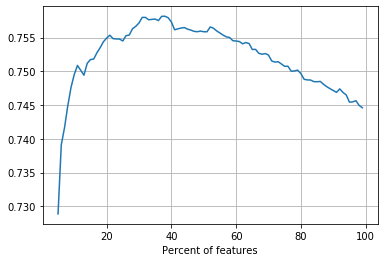

In [5]:
model = LogisticRegression(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(train_x, y_train)    
    cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [7]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
selectp = SelectPercentile(percentile=best_score[0]).fit(train_x, y_train)
X_train_sel = selectp.transform(train_x)
X_test_sel = selectp.transform(test_x)

In [6]:
best_score[0]

38

In [8]:
X_train_sel.shape


(3500, 40)

In [11]:
pd.DataFrame(X_train_sel).to_csv('train_numbersOfPurchase_nm_percentile.csv', index=False, encoding='cp949')
pd.DataFrame(X_test_sel).to_csv('test_numbersOfPurchase_nm_percentile.csv', index=False, encoding='cp949')


### 4. Modeling & Evaluation - Build Models with Hyperparameter Optimization

In [7]:
# 학습데이터 70%, 평가데이터 30%로 데이터 분할
X_train, X_valid, y_train, y_valid = train_test_split(X_train_sel, y_train, test_size=0.3, random_state=0)

In [8]:
clfs = [
   (
        KNeighborsClassifier(),              # 사용하려는 모델
        {'n_neighbors': [3,5,7,9,11],        # 최적화하려는 하이퍼파라미터
         'weights': ['uniform','distance']}
    ),
    (
        MLPClassifier(random_state=0),
        {'batch_size': [32, 64, 128],
         'learning_rate' : ['constant', 'adaptive'],
         'activation': ['tanh', 'relu'],
         'solver': ['sgd', 'adam']}
    ),
    (
        LogisticRegression(random_state=0),  
        {'C': np.arange(0.1, 1.1, 0.1),      
         'penalty': ['l1','l2']}
    ),
    (
        RandomForestClassifier(random_state=0),
        {'n_estimators': [100,200,300],
         'max_depth': [3,4,5],}
        # 'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int)}
    ),
    (
        GradientBoostingClassifier(random_state=0),
        {'n_estimators': [100, 200, 300],
         'learning_rate': [1, 0.1, 0.01],}
        # 'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int)}
    ),
    (
        XGBClassifier(tree_method = 'hist', random_state=0),
        {'min_child_weight': range(0, 121, 20),
         'learning_rate': np.arange(0.1, 0.6, 0.1),
         'subsample': np.arange(0.5, 1.0, 0.1)}
    ),
    (
        LGBMClassifier(random_state=0),
        {'min_child_weight': range(0, 121, 20),
         'learning_rate': np.arange(0.1, 0.6, 0.1),
         'subsample': np.arange(0.5, 1.0, 0.1)}
    ),
]

clfs_tuned = []  # 튜닝된 모델을 저장
for clf, param_grid in tqdm(clfs):
    start = time.time()
    rand_search = RandomizedSearchCV(clf, param_grid, n_iter=5, scoring='roc_auc', 
                                     cv=3, random_state=0, n_jobs=-1)
    rand_search.fit(X_train, y_train)
    clf_name = type(clf).__name__
    clf_score = rand_search.score(X_valid, y_valid)
    print('{:30s} {:30f} {:.1f}'.format(clf_name, clf_score, time.time() - start))
    clfs_tuned.append((clf_name, rand_search, clf_score))

 14%|████████████                                                                        | 1/7 [00:02<00:14,  2.43s/it]

KNeighborsClassifier                                 0.703303 2.4


 29%|████████████████████████                                                            | 2/7 [00:14<00:26,  5.38s/it]

MLPClassifier                                        0.757806 12.3
LogisticRegression                                   0.760934 0.1


 57%|████████████████████████████████████████████████                                    | 4/7 [00:19<00:13,  4.49s/it]

RandomForestClassifier                               0.727649 4.7


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:36<00:16,  8.09s/it]

GradientBoostingClassifier                           0.728244 16.5


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:38<00:06,  6.55s/it]

XGBClassifier                                        0.729869 3.0


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:39<00:00,  5.66s/it]

LGBMClassifier                                       0.738676 0.7


### 4. Modeling & Evaluation - Ensemble Models

*Correlation between models*

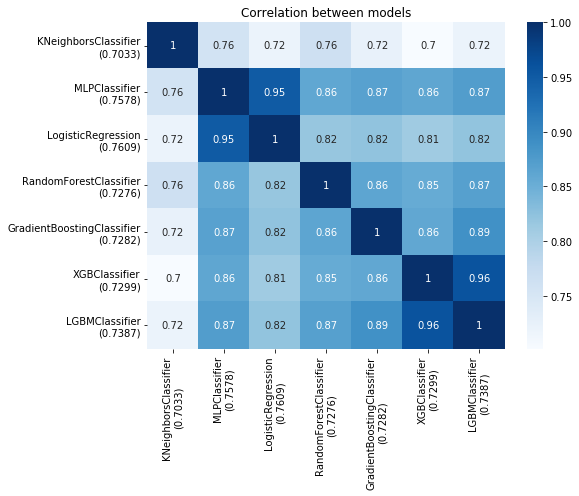

In [9]:
pred_results = []
for name, clf, clf_score in clfs_tuned:
    pred = clf.predict_proba(X_valid)[:,1]
    name = f'{name}\n({clf_score:.4f})'
    pred_results.append(pd.Series(pred, name=name))
ensemble_results = pd.concat(pred_results, axis=1)

# 모형의 예측값 간의 상관관계를 보기 위해 hitmap을 도식한다.
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(), annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()

*Averaging Ensemble*

In [10]:
# Averaging 앙상블에 사용하지 않을 모델은 주석 처리하세요.
selected = [
    'KNeighborsClassifier', 
    'MLPClassifier',
    'LogisticRegression', 
    'RandomForestClassifier', 
    'GradientBoostingClassifier',    
    'XGBClassifier',
    'LGBMClassifier',
]
models_for_ensemble = [clf for clf in clfs_tuned if clf[0] in selected]

In [27]:
models_for_ensemble

[('KNeighborsClassifier',
  RandomizedSearchCV(cv=3, error_score=nan,
                     estimator=KNeighborsClassifier(algorithm='auto',
                                                    leaf_size=30,
                                                    metric='minkowski',
                                                    metric_params=None,
                                                    n_jobs=None, n_neighbors=5,
                                                    p=2, weights='uniform'),
                     iid='deprecated', n_iter=5, n_jobs=-1,
                     param_distributions={'n_neighbors': [3, 5, 7, 9, 11],
                                          'weights': ['uniform', 'distance']},
                     pre_dispatch='2*n_jobs', random_state=0, refit=True,
                     return_train_score=False, scoring='roc_auc', verbose=0),
  0.703303048214796),
 ('MLPClassifier',
  RandomizedSearchCV(cv=3, error_score=nan,
                     estimator=MLPClassifi

In [11]:
max_score = 0
for p in tqdm([0, 1, 2.56]):  # p==1:산술평균, p=0:기하평균, 그 외:멱평균(주의:멱평균은 과적합 가능성이 높음)    
    for i in range(2, len(models_for_ensemble)+1):
        for models in combinations(models_for_ensemble, i):
            if p == 0:
                pred_mean = gmean([clf.predict_proba(X_valid)[:,1] for name, clf, _ in models], axis=0)
            else:
                preds = [clf.predict_proba(X_valid)[:,1] for name, clf, _ in models]
                pred_mean = (np.sum(np.array(preds)**p, axis=0) / len(models))**(1/p)
            score = roc_auc_score(y_valid, pred_mean)
            if max_score < score:
                best_avg_ensemble = (p, models, score)
                max_score = score

p, models, score = best_avg_ensemble
print('p={}\n{}\n{}'.format(p, '●'.join([clf_name for clf_name, _, _ in models]), score))

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:39<00:00, 13.18s/it]

p=0
MLPClassifier●LogisticRegression
0.7623237989360411


*Stacking*

In [12]:
from vecstack import StackingTransformer

# Initialize 1st level estimators
# 사용하지 않을 모델은 주석 처리하세요.
selected = [
    'KNeighborsClassifier', 
    'MLPClassifier',
    'LogisticRegression', 
    'RandomForestClassifier', 
    'GradientBoostingClassifier',    
    'XGBClassifier',
    'LGBMClassifier',
]
estimators = [(name, clf) for name, clf, _ in clfs_tuned if name in selected]
              
# Initialize StackingTransformer
stack = StackingTransformer(estimators, regression=False, needs_proba=True, metric=None,
                            n_folds=3, stratified=True, shuffle=True, random_state=0)

# Fit
stack = stack.fit(X_train, y_train)

# Get your stacked features
S_train = stack.transform(X_train)
S_valid = stack.transform(X_valid)
S_test = stack.transform(X_test_sel)

# Use 2nd level estimator with stacked features
meta_model = LogisticRegression().fit(S_train, y_train)
print(roc_auc_score(y_valid, meta_model.predict_proba(S_valid)[:,1]))  

0.761544815059833


### 5. Deployment

In [13]:
# Apply the best averaging ensemble model to Unseen Data
if p == 0:
    pred_mean = gmean([clf.predict_proba(X_test_sel)[:,1] for name, clf, _ in models], axis=0)
else:
    preds = [clf.predict_proba(X_test_sel)[:,1] for name, clf, _ in models]
    pred_mean = (np.sum(np.array(preds)**p, axis=0) / len(models))**(1/p)
pd.DataFrame({'cust_id': IDtest, 'gender': pred_mean}).to_csv('avg_submission.csv', index=False)

# Apply the stacking model to Unseen Data
pd.DataFrame({'cust_id': IDtest, 'gender': meta_model.predict_proba(S_test)[:,1]}).to_csv('stk_submission.csv', index=False)

# Apply the best single model to Unseen Data
best_model = clfs_tuned[np.argmax([score for _, _, score in clfs_tuned])][1]
pd.DataFrame({'cust_id': IDtest, 'gender': best_model.predict_proba(X_test_sel)[:,1]}).to_csv('bst_submission.csv', index=False)

<font color="#CC3D3D"><p>
# End